# Task b

Frederik Rogge, Mouhammad Abu Rasheed and Homa Priya Tarigopula

In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
#from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_validate
import matplotlib.pyplot as plt
from sklearn.utils import resample
import os
%matplotlib inline
from models import *

from copy import deepcopy
np.random.seed(0)


In [2]:
# Create data
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)
x, y = np.meshgrid(x, y)

def FrankeFunction(x, y):
    """
    Returns value of Franke function at (x, y).
    """    
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4


# Compute z
z = FrankeFunction(x, y)

# Create features as pairs of (x, y)
features = np.stack([x.ravel(), y.ravel()], axis=1)


# Get labels
labels = z.ravel()
labels = labels.reshape((-1,1))


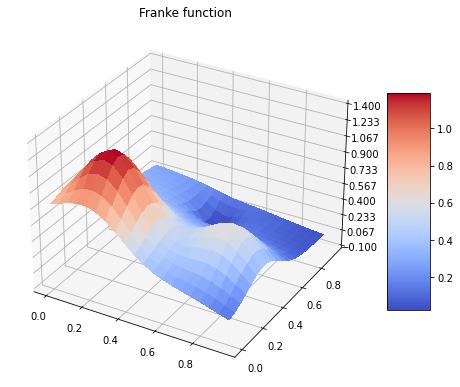

In [3]:
def plot_function(x, y, z, title=None):
    # Plot function
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface.
    surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

    ax.set_zlim(-0.10, 1.40)
    ax.zaxis.set_major_locator(LinearLocator(10))

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    if title is not None:
        plt.title(title)
    
    plt.show()
    
plot_function(x, y, z, 'Franke function')

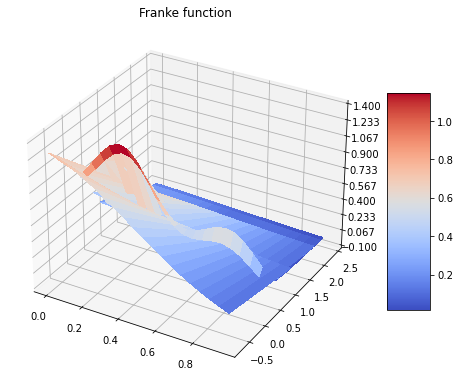

In [4]:

    

x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)
y= y+np.random.normal(0 , 1.0 , y.shape )
x, y = np.meshgrid(x, y)

def FrankeFunction(x, y):
    """
    Returns value of Franke function at (x, y).
    """    
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4


# Compute z
z = FrankeFunction(x, y)

# Create features as pairs of (x, y)
features = np.stack([x.ravel(), y.ravel()], axis=1)


# Get labels
labels = z.ravel()
labels = labels.reshape((-1,1))

plot_function(x, y, z, 'Franke function')

### Part b) : Bias Variance trade-off on Franke function

#### Refer task 1 for MSE as a function of complexity 

### Part b) : Bootstrap Resampling technique

In [5]:
def bias_variance_error(y_test, y_pred):
    error = np.mean( np.mean((y_test - y_pred)**2, axis=1, keepdims=True) )
    bias = np.mean( (y_test - np.mean(y_pred, axis=1, keepdims=True))**2 )
    variance = np.mean( np.var(y_pred, axis=1, keepdims=True) )
    return error, bias, variance

def bootstrap(X_train, y_train, x_test, y_test,
              percentage_of_train_data=1.0, degree_of_polynomial=14,
              scaling=False, add_noise=False, mean=0.0, std=0.1,
              number_of_bootstraps=100,solver=LinearRegression, **solver_args):
    e_ = np.zeros(degree_of_polynomial-1)
    b_ = np.zeros(degree_of_polynomial-1)
    v_ = np.zeros(degree_of_polynomial-1)
    X_train_actual= deepcopy(X_train)
    y_train_actual= deepcopy(y_train)
    
    indices = np.random.choice(len(y_train), int(percentage_of_train_data*len(y_train)), replace=False)
    X_train, y_train = X_train_actual[indices], y_train_actual[indices]
    # iterate over the polyniomial degree
    for d in range(1,degree_of_polynomial):
        #scale data if necessary
        if scaling == True:
            model = make_pipeline(PolynomialFeatures(degree=d ),StandardScaler(with_std= True), solver(**solver_args))
        else:
            model = make_pipeline(PolynomialFeatures(degree=d), solver(**solver_args))
        #resample and estimate the bias, varaince  and error on the test data
        y_pred = np.zeros((y_test.shape[0], number_of_bootstraps))
        for b in range(number_of_bootstraps):
            x_, y_ = resample(X_train,y_train, random_state=b)

            model_output = model.fit(x_, y_).predict(x_test).ravel()
            #print('here ', x_.shape, y_.shape, x_test.shape, model_output.shape)
            y_pred[:,b]=model_output
        error, bias, var= bias_variance_error(y_test, y_pred)

        e_[d-1]= error
        b_[d-1]= bias
        v_[d-1]= var
    return e_, b_, v_

#### Bootstrap bias variance tradeoff -1

Here we examine ths bias-variance tradeoff on the test set without noise and without scaling

(320, 1) (80, 1)


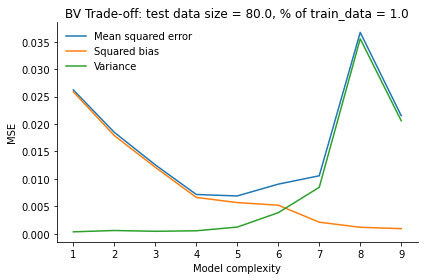

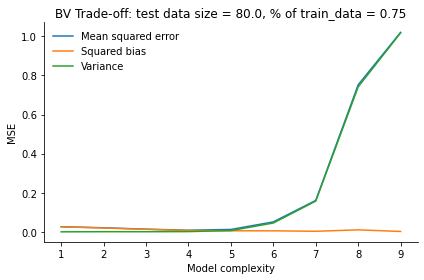

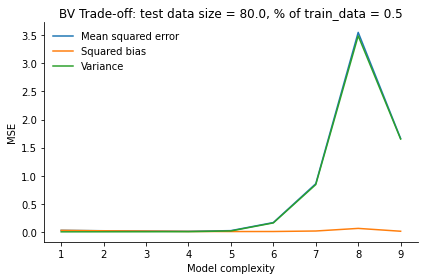

In [6]:
degree_of_polynomial=10
add_noise= False

if add_noise :
    np.random.seed(1)
    labels_n = labels +  np.random.normal(0 , 1, labels.shape )
else :
    labels_n = labels
    
#define the input argumets for the solver 
solver_args ={ 'fit_intercept': True }

# Hold out some test data that is never used in training.
X_train, x_test, y_train, y_test = train_test_split(features, labels_n, 
                                                    test_size=0.2, random_state = 2021)


print(y_train.shape, y_test.shape)
for dat in [1.0, 0.75, 0.5]:
    e,b,v = bootstrap(X_train=X_train, y_train=y_train, x_test=x_test, y_test=y_test,
                  percentage_of_train_data= dat, degree_of_polynomial=degree_of_polynomial,
                  scaling=False,
                  number_of_bootstraps=5000,solver=LinearRegression, **solver_args)

    polynomial = np.arange(1, degree_of_polynomial)
    title = 'BV Trade-off: test data size = '+str(np.round(0.2*len(labels), 2))+', % of train_data = '+ str(dat)
    plot_metric(y=[e,b,v], x= polynomial, show= True, title=title , name='b_without_noise_without_scaling_'+ str(dat)+'.png', x_label='Model complexity', y_label='MSE',  save=True, legend = ['Mean squared error','Squared bias','Variance'])

#### Bootstrap bias variance tradeoff - 2

Here we examine ths bias-variance tradeoff on the test set without noise and with scaling

(320, 1) (80, 1)


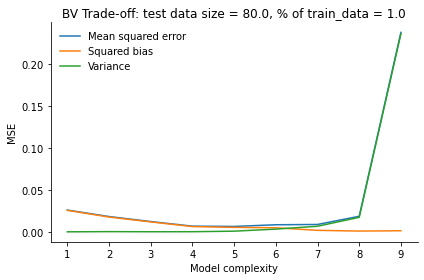

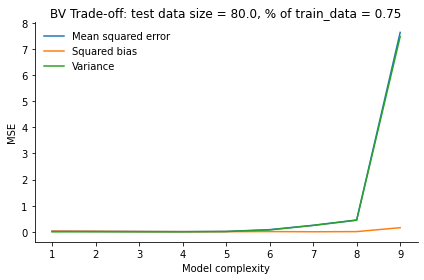

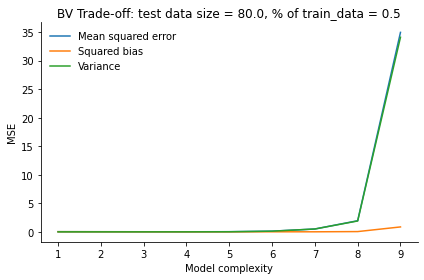

In [7]:
add_noise= False
degree_of_polynomial=10
if add_noise :
    np.random.seed(1)
    labels_n = labels +  np.random.normal(0 , 1, labels.shape )
else :
    labels_n = labels
    
#define the input argumets for the solver 
solver_args ={ 'fit_intercept': True }

# Hold out some test data that is never used in training.
X_train, x_test, y_train, y_test = train_test_split(features, labels_n, 
                                                    test_size=0.2, random_state = 2021)


print(y_train.shape, y_test.shape)
for dat in [1.0, 0.75, 0.5]:
    e,b,v = bootstrap(X_train=X_train, y_train=y_train, x_test=x_test, y_test=y_test,
                  percentage_of_train_data= dat, degree_of_polynomial=degree_of_polynomial,
                  scaling=True,
                  number_of_bootstraps=5000,solver=LinearRegression, **solver_args)

    polynomial = np.arange(1, degree_of_polynomial)
    title = 'BV Trade-off: test data size = '+str(np.round(0.2*len(labels), 2))+', % of train_data = '+ str(dat)
    plot_metric(y=[e,b,v], x= polynomial, show= True, title=title , name='b_without_noise_with_scaling_'+ str(dat)+'.png', x_label='Model complexity', y_label='MSE',  save=True, legend = ['Mean squared error','Squared bias','Variance'])

   

#### Bootstrap bias variance tradeoff - 3

Here we examine ths bias-variance tradeoff on the test set with noise and with scaling

(320, 1) (80, 1)


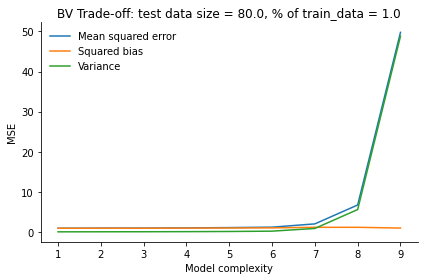

[ 0.90987217  0.93539585  0.9428863   0.99280839  1.06633186  1.17187728
  1.99168363  6.70998756 49.77815139] [0.89973782 0.91397885 0.91004676 0.93829285 0.96943091 0.99453871
 1.13841899 1.13840546 0.94666168] [1.01343510e-02 2.14170085e-02 3.28395441e-02 5.45155427e-02
 9.69009534e-02 1.77338570e-01 8.53264640e-01 5.57158209e+00
 4.88314897e+01]


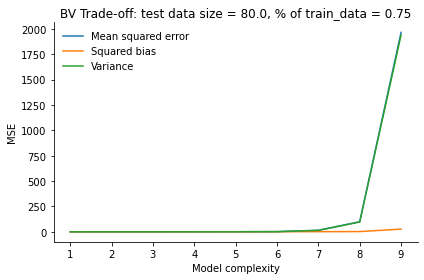

[9.17858149e-01 9.99964807e-01 1.00090389e+00 1.07310198e+00
 1.29189204e+00 2.31567693e+00 1.52313781e+01 9.93789119e+01
 1.96598839e+03] [ 0.90554924  0.97419515  0.95691881  0.99577753  1.02985052  1.18080495
  1.51389914  2.60775189 26.79258651] [1.23089058e-02 2.57696540e-02 4.39850835e-02 7.73244456e-02
 2.62041521e-01 1.13487198e+00 1.37174789e+01 9.67711600e+01
 1.93919580e+03]


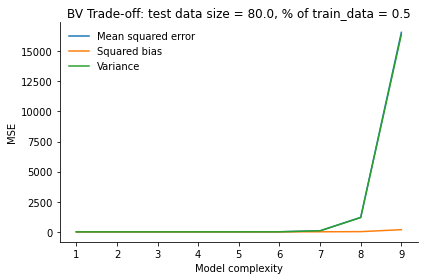

[9.47634017e-01 1.03002565e+00 1.04865065e+00 1.22635795e+00
 1.89669042e+00 5.38478045e+00 8.63485851e+01 1.20224246e+03
 1.65658649e+04] [  0.92919658   0.99069283   0.97676449   1.05190537   1.08071183
   1.20119982   2.69861169  16.30403134 178.28011782] [1.84374353e-02 3.93328204e-02 7.18861597e-02 1.74452581e-01
 8.15978590e-01 4.18358062e+00 8.36499734e+01 1.18593843e+03
 1.63875847e+04]


In [8]:
add_noise= True
degree_of_polynomial=10
if add_noise :
    np.random.seed(1)
    labels_n = labels +  np.random.normal(0 , 1, labels.shape )
else :
    labels_n = labels
    
#define the input argumets for the solver 
solver_args ={ 'fit_intercept': True }

# Hold out some test data that is never used in training.
X_train, x_test, y_train, y_test = train_test_split(features, labels_n, 
                                                    test_size=0.2, random_state = 2021)


print(y_train.shape, y_test.shape)
for dat in [1.0, 0.75, 0.5]:
    e,b,v = bootstrap(X_train=X_train, y_train=y_train, x_test=x_test, y_test=y_test,
                  percentage_of_train_data= dat, degree_of_polynomial=degree_of_polynomial,
                  scaling=True,
                  number_of_bootstraps=5000,solver=LinearRegression, **solver_args)

    polynomial = np.arange(1, degree_of_polynomial)
    title = 'BV Trade-off: test data size = '+str(np.round(0.2*len(labels), 2))+', % of train_data = '+ str(dat)
    plot_metric(y=[e,b,v], x= polynomial, show= True, title=title , name='b_with_noise_with_scaling_'+ str(dat)+'.png', x_label='Model complexity', y_label='MSE',  save=True, legend = ['Mean squared error','Squared bias','Variance'])
    
    print(e,b,v)
